# やること(変更点)
1. 

# first ESN

## ESN1, output, input class
input, output, middle layer

In [ ]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import networkx as nx
from numpy.random import RandomState
import matplotlib.pyplot as plt

class Input_external:
    def __init__(self, dim_u, dim_x, input_scale, dtype=np.float32, rseed=0):
        '''
        dim_u: Dimension of the input
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        self.dtype = dtype
        #only first neuron receives noise
        self.w_in = np.zeros((dim_x, dim_u))
        self.w_in[:, 0]=np.random.uniform(-input_scale, input_scale, dim_u).T
        #self.w_in = np.random.uniform(-input_scale, input_scale, (dim_x, dim_u))
        self.w_in = self.w_in.astype(self.dtype)
    
    def __call__(self, u):
        u = u.astype(self.dtype)
        return np.dot(self.w_in, u)

class Input_spon:
    def __init__(self, dim_u_spon, dim_x, eps=0.20, r=4.0, dtype=np.float32, rseed=0):
        '''
        dim_u_spon: Dimension of the input from sponttaneous activities
        dim_x: Dimension of the reservoir states = Number of nodes in the Reservoir Network
        input_scale: Scaling coefficient for the input
        '''
        np.random.seed(seed=rseed)
        input_scale=1.0 # variant for buf
        self.dtype = dtype
        self.w_in = np.random.uniform(-input_scale, input_scale, (dim_x, dim_u_spon))
        self.w_in = self.w_in.astype(self.dtype)

        self.eps=eps # diffusive coupling strength
        self.r=r # control parameter r
        L = 2      # no. of lattice sites
        ic = np.random.uniform(0.1, 0.9, (L, dim_u_spon))  # random initial condition betn. (0,1)
        print("spon_act_CML2d_ic = ", ic)
        self.CML2d=ic
        self.x_in_series=[] #1st_dim: time, 2nd_dim: input_dim(dim_u_spon)
    
    def logistic(self, r, xforlog):
        return r*xforlog*(1-xforlog)
    
    def func1(self, a, x):
        return 1-(a*x)*x
    
    def next_x(self, f, x_2d):
        x_new = np.empty(x_2d.shape)
        x_new[0] = (1 - self.eps) * f(self.r,x_2d[0]) + self.eps * f(self.r,x_2d[1])
        x_new[1] = (1 - self.eps) * f(self.r,x_2d[1]) + self.eps * f(self.r,x_2d[0])
        return x_new

    def get_x_in(self):
        return np.array(self.x_in_series)

    def __call__(self):
        self.CML2d = self.next_x(self.logistic, self.CML2d).astype(self.dtype)# intermittent activities 2dCML or ESNnetwork
        self.x_in_spon=self.CML2d[0]-self.CML2d[1]
        #print(self.CML2d)
        self.x_in_series.append(self.x_in_spon)
        return np.dot(self.w_in, self.x_in_spon)# x_in is row or clumn??????

class ESN1:
    def __init__(self, dim_x, activation_func=np.tanh, dtype=np.float32, rho=0.9,
        x_init=None, rseed=None, density=None):
        '''
        dim_x:           Dimension of the reservori states = Number of nodes in the Reservoir Network
        activation_func: Activation function to evolve the previous internal states
        rho:             Specified spectral radius for the internal weights matrix
        density:         Density of connection in the Reservoir layer
        '''
        self.dim_x = dim_x
        self.f = activation_func
        self.dtype = dtype
        self.rho = rho # speficy the spectral radius
        
        if x_init is None:
            self.x_init = np.zeros(dim_x, dtype=self.dtype)
        else:
            self.x_init = np.array(x_init, dtype=self.dtype)
        self.x = np.array(self.x_init)
        self.rseed = rseed
        self.rnd = RandomState(rseed)
        
        # initializing internal connections
        self.reset_weight(density)
    
    def reset_weight(self, density=None):
        """
        self.density = 1.0 if density is None else density
        num_edges = int(self.dim_x * (self.dim_x - 1) * self.density / 2)
        
        G = nx.gnm_random_graph(self.dim_x, num_edges, self.rseed)
        self.w_net = np.array(nx.to_numpy_matrix(G))
        self.w_net = self.w_net.astype(self.dtype)
        """
        self.w_net = np.zeros((self.dim_x, self.dim_x))
        for i in range(self.dim_x):
            for j in range(self.dim_x):
                tmp=0
                while -0.5<tmp and tmp<0.5:
                    tmp=self.rnd.uniform(-1.0, 1.0)
                self.w_net[i,j]=tmp
        #self.rnd.uniform(-1.0, 1.0, (self.dim_x, self.dim_x))
        
        # Compute spectral radius Normalization
        #"""
        eigv_list = np.linalg.eig(self.w_net)[0]
        spectral_radius = np.max(np.abs(eigv_list))
        print("ESN1, spectral_radius = ", spectral_radius)
        
        # Normalize the spectral radius
        self.w_net  *= self.rho / spectral_radius
        #"""
        """
        self.w_net  =[[1.0, 0.1, -0.9, -0.3],
                      [0.5, 0.9, 0.2, 0.0],
                      [-0.7, 0.4, -0.3, 0.1],
                      [0.5, 0.1, 0.2, 1.0]]
        """

    def f_act(self, x=None):
        if x is None:
            x = self.x
        return self.f(x)
    
    def update(self, x_in):
        x_in = x_in.astype(self.dtype)
        self.x = self.f_act(np.dot(self.w_net, self.x))+x_in
        """
        x_for_actfunc=np.dot(self.w_net, self.x) + x_in # self.x_init = np.zeros(dim_x, dtype=self.dtype)
        for i in range(self.dim_x):
          self.x[i] = self.f_act(x_for_actfunc[i])
        """

    def reset_states(self, x_init=None):# not used 
        if x_init is None:
            x_init = self.x_init
        self.x = np.array(x_init)

    def get_states(self):
        return self.x

class Readout:
    def __init__(self, dim_x, dim_out, rseed=0):
        np.random.seed(seed=rseed)
        self.w_out = np.random.normal(size=(dim_out, dim_x))
    
    def __call__(self, x):
        return np.dot(self.w_out, x)
    
    def set_weight(self, w_out_opt):
        self.w_out = w_out_opt


## Discrete ESN for checking state values

In [ ]:
class DESN_2kindsInput_1(ESN1):
    '''
    Discrete-time echo state network
    Inherit from ESN abstract class
    Add the Input and Readout layers
    
    #Variables including default params have order to define in any function 
    '''
    def __init__(self, dim_u_ex, dim_u_spon, dim_rv, input_scale, activation_func, spon_eps=0.20, spon_r=4.0, dim_out=0,**kwargs):
        #dim_rv: Dimension of the reservoir states
        super(DESN_2kindsInput_1, self).__init__(dim_rv, activation_func=activation_func, **kwargs)#assign dim_rv to dim_x
        #create instance
        self.Input_external = Input_external(dim_u_ex, dim_rv, input_scale)
        self.Input_spon = Input_spon(dim_u_spon, dim_rv, eps=spon_eps, r=spon_r, rseed=10)
        
        self.Readout = Readout(dim_rv, dim_out)
        self.states_series=[]
        self.dim_u_spon=dim_u_spon
        self.dim_u_ex=dim_u_ex

    def one_step(self, u_in):
        '''
        One-step evolution
        '''
        # Contribution from input
        x_in_external = self.Input_external(u_in)
        # Contribution from spontaneous activities
        x_in_spon = self.Input_spon()
        # Update with previous states and activation function
        self.update((x_in_external + x_in_spon)/(self.dim_u_spon + self.dim_u_ex) )

    def time_elapse(self, u_seq, washout_len = 200):
        '''
        Do not use the data in the washout phase for training
        '''
        for i in range(len(u_seq)):
            # Update the reservoir states
            self.one_step(u_seq[i])
            if i >= washout_len: 
              # True: use data
              self.states_series.append(self.get_states())
        return np.array(self.states_series)
    
    def predict(self, u_seq):
        '''
        Given the input sequence u_seq, predict the unknown output sequence
        Using the trained readout weights
        '''
        Y_pred_seq = []
        for i in range(len(u_seq)):
            self.one_step(u_seq[i])
            x_bias = np.concatenate([np.ones(1), self.x])
            y_pred = self.Readout(x_bias)
            Y_pred_seq.append(y_pred)
        return np.array(Y_pred_seq)

## Observation of DESN with spontaneous acts

np.diff(): 渡した配列の階差数列を配列で返す関数

In [ ]:
def DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed, activation_func, spon_eps=0.20, spon_r=4.0, plot=True, verbose=False):
    # Obtain the dimension of input and output
    dim_u_ex = u_ex.shape[1]
    Time_leng=u_ex.shape[0]
    dim_u_spon=dim_u_spon
    #dim_out = train_y.shape[1]
    #print("dim_out = ",dim_out)
    
    # Define the model
    model = DESN_2kindsInput_1(dim_u_ex=dim_u_ex, dim_u_spon=dim_u_spon, dim_rv=dim_rv, 
                             density=density, input_scale=input_scale, activation_func=activation_func, spon_eps=0.20, spon_r=4.0, rho=rho, rseed=rseed)
    
    washout_len=200
    # Time elapsed (時間が経過した-> 時間経過)
    states_series = model.time_elapse(u_ex, washout_len=washout_len) # 1st_dim: time, 2nd: nodes.
    x_in_spon=model.Input_spon.get_x_in()
    # Predict
    """
    test_pred = model.predict(test_u)
    print("test_pred.shape", test_pred.shape)
    """
    # Evaluate
    
    # For Debug
    if verbose == True:
        print("Debug")
        print("dim_u = ",dim_u)
        print("x_in_spon.shape = ", x_in_spon.shape)
        print("states_series.shape = ", states_series.shape)

     # Plot the target
    if (plot == True and dim_u_spon == 0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(2,1)

        time=np.arange(Time_leng)

        bar1=ax1[0].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[0].set_xlabel('time')
        ax1[0].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[1].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[1])
    
    # Plot the targett with spon_act
    if (plot == True and dim_u_spon>0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(3,1)

        time=np.arange(Time_leng)
        plot_len=2000
        ax1[0].plot(time[-plot_len:], x_in_spon[-plot_len:])

        bar1=ax1[1].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[2].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[2].set_xlabel('time')
        ax1[2].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[2])

        plt.show()
    return washout_len, states_series


# second ESN

## ESN2
input, output, middle layer

In [ ]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
import networkx as nx
from numpy.random import RandomState
import matplotlib.pyplot as plt

class ESN2:
    def __init__(self, dim_x, activation_func=np.tanh, dtype=np.float32, rho=0.9,
        x_init=None, rseed=None, density=None):
        '''
        dim_x:           Dimension of the reservori states = Number of nodes in the Reservoir Network
        activation_func: Activation function to evolve the previous internal states
        rho:             Specified spectral radius for the internal weights matrix
        density:         Density of connection in the Reservoir layer
        '''
        self.dim_x = dim_x
        self.f = activation_func
        self.dtype = dtype
        self.rho = rho # speficy the spectral radius
        
        if x_init is None:
            self.x_init = np.zeros(dim_x, dtype=self.dtype)
            self.x_init[0]=0.01
        else:
            self.x_init = np.array(x_init, dtype=self.dtype)
        self.x = np.array(self.x_init)
        self.rseed = rseed
        self.rnd = RandomState(rseed)
        
        # initializing internal connections
        self.reset_weight(density)
    
    def reset_weight(self, density=None):
        """
        self.density = 1.0 if density is None else density
        num_edges = int(self.dim_x * (self.dim_x - 1) * self.density / 2)
        
        G = nx.gnm_random_graph(self.dim_x, num_edges, self.rseed)
        self.w_net = np.array(nx.to_numpy_matrix(G))
        self.w_net = self.w_net.astype(self.dtype)
        self.w_net *= self.rnd.uniform(-1.0, 1.0, (self.dim_x, self.dim_x))
        """
        self.w_net = np.zeros((self.dim_x, self.dim_x))
        for i in range(self.dim_x):
            for j in range(self.dim_x):
                tmp=0
                while -0.5<tmp and tmp<0.5:
                    tmp=self.rnd.uniform(-1.0, 1.0)
                self.w_net[i,j]=tmp
        
        # Compute spectral radius and Normalization
        eigv_list = np.linalg.eig(self.w_net)[0]
        spectral_radius = np.max(np.abs(eigv_list))
        print("ESN2, spectral_radius = ", spectral_radius)

        # Normalize the spectral radius
        self.w_net  *= self.rho / spectral_radius
        #"""
        """
        self.w_net  =[[1.1, 0.1, -0.9, -0.3],
                      [0.5, 0.9, 0.2, 0.0],
                      [-0.7, 0.4, -0.3, 0.1],
                      [0.5, 0.1, 0.2, 1.0]]
        """

    def f_act(self, x=None):
        if x is None:
            x = self.x
        return self.f(x)
    
    def update(self, x_in):
        x_in = x_in.astype(self.dtype)
        self.x = self.f_act(np.dot(self.w_net, self.x))+x_in

        """
        x_for_actfunc=np.dot(self.w_net, self.x) + x_in # self.x_init = np.zeros(dim_x, dtype=self.dtype)
        for i in range(self.dim_x):
          self.x[i] = self.f_act(x_for_actfunc[i])
        """


    def reset_states(self, x_init=None):# not used 
        if x_init is None:
            x_init = self.x_init
        self.x = np.array(x_init)

    def get_states(self):
        return self.x


## Discrete ESN for checking state values

In [ ]:
class DESN_2kindsInput_2(ESN2):
    '''
    Discrete-time echo state network
    Inherit from ESN abstract class
    Add the Input and Readout layers
    
    #Variables including default params have order to define in any function 
    '''
    def __init__(self, dim_u_ex, dim_u_spon, dim_rv, input_scale, activation_func, spon_eps=0.20, spon_r=4.0, dim_out=0,**kwargs):
        #dim_rv: Dimension of the reservoir states
        super(DESN_2kindsInput_2, self).__init__(dim_rv, activation_func=activation_func, **kwargs)#assign dim_rv to dim_x
        #create instance
        self.Input_external = Input_external(dim_u_ex, dim_rv, input_scale)
        self.Input_spon = Input_spon(dim_u_spon, dim_rv, eps=spon_eps, r=spon_r, rseed=11)
        
        self.Readout = Readout(dim_rv, dim_out)
        self.states_series=[]
        self.dim_u_spon=dim_u_spon
        self.dim_u_ex=dim_u_ex

    def one_step(self, u_in):
        '''
        One-step evolution
        '''
        # Contribution from input
        x_in_external = self.Input_external(u_in)
        # Contribution from spontaneous activities
        x_in_spon = self.Input_spon()
        # Update with previous states and activation function
        self.update((x_in_external + x_in_spon)/(self.dim_u_spon + self.dim_u_ex) )

    def time_elapse(self, u_seq, washout_len = 200):
        '''
        Do not use the data in the washout phase for training
        '''
        for i in range(len(u_seq)):
            # Update the reservoir states
            self.one_step(u_seq[i])
            if i >= washout_len: 
              # True: use data
              self.states_series.append(self.get_states())
        return np.array(self.states_series)
    
    def predict(self, u_seq):
        '''
        Given the input sequence u_seq, predict the unknown output sequence
        Using the trained readout weights
        '''
        Y_pred_seq = []
        for i in range(len(u_seq)):
            self.one_step(u_seq[i])
            x_bias = np.concatenate([np.ones(1), self.x])
            y_pred = self.Readout(x_bias)
            Y_pred_seq.append(y_pred)
        return np.array(Y_pred_seq)

## Observation of DESN with spontaneous acts

np.diff(): 渡した配列の階差数列を配列で返す関数

In [ ]:
def DESN_observer_2(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed, activation_func, spon_eps=0.20, spon_r=4.0, plot=True, verbose=False):
    # Obtain the dimension of input and output
    dim_u_ex = u_ex.shape[1]
    Time_leng=u_ex.shape[0]
    dim_u_spon=dim_u_spon
    #dim_out = train_y.shape[1]
    #print("dim_out = ",dim_out)
    
    # Define the model
    model = DESN_2kindsInput_2(dim_u_ex=dim_u_ex, dim_u_spon=dim_u_spon, dim_rv=dim_rv, 
                             density=density, input_scale=input_scale, activation_func=activation_func, spon_eps=0.20, spon_r=4.0, rho=rho, rseed=rseed)
    
    washout_len=200
    # Time elapsed (時間が経過した-> 時間経過)
    states_series = model.time_elapse(u_ex, washout_len=washout_len) # 1st_dim: time, 2nd: nodes.
    x_in_spon=model.Input_spon.get_x_in()
    # Predict
    """
    test_pred = model.predict(test_u)
    print("test_pred.shape", test_pred.shape)
    """
    # Evaluate
    
    # For Debug
    if verbose == True:
        print("Debug")
        print("dim_u = ",dim_u)
        print("x_in_spon.shape = ", x_in_spon.shape)
        print("states_series.shape = ", states_series.shape)

     # Plot the target
    if (plot == True and dim_u_spon == 0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(2,1)

        time=np.arange(Time_leng)

        bar1=ax1[0].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[0].set_xlabel('time')
        ax1[0].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[1].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[1])
    
    # Plot the targett with spon_act
    if (plot == True and dim_u_spon>0):
        plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
        plt.rcParams['font.size'] = 20
        fig=plt.figure()
        ax1=fig.subplots(3,1)

        time=np.arange(Time_leng)
        plot_len=2000
        ax1[0].plot(time[-plot_len:], x_in_spon[-plot_len:])

        bar1=ax1[1].imshow(states_series.T, cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[1].set_xlabel('time')
        ax1[1].set_ylabel('nodes')
        fig.colorbar(bar1, ax=ax1[1])

        bar2=ax1[2].imshow(states_series.T[:, -300:], cmap='bwr', interpolation='nearest', aspect='auto')
        ax1[2].set_xlabel('time')
        ax1[2].set_ylabel('nodes')
        fig.colorbar(bar2, ax=ax1[2])

        plt.show()
    return washout_len, states_series


# 2ESN and difference

ESN1, spectral_radius =  8.303656794200242
spon_act_CML2d_ic =  []
Debug
dim_u =  1
x_in_spon.shape =  (8000, 0)
states_series.shape =  (7800, 100)
ESN2, spectral_radius =  8.303656794200242
spon_act_CML2d_ic =  []
Debug
dim_u =  1
x_in_spon.shape =  (8000, 0)
states_series.shape =  (7800, 100)


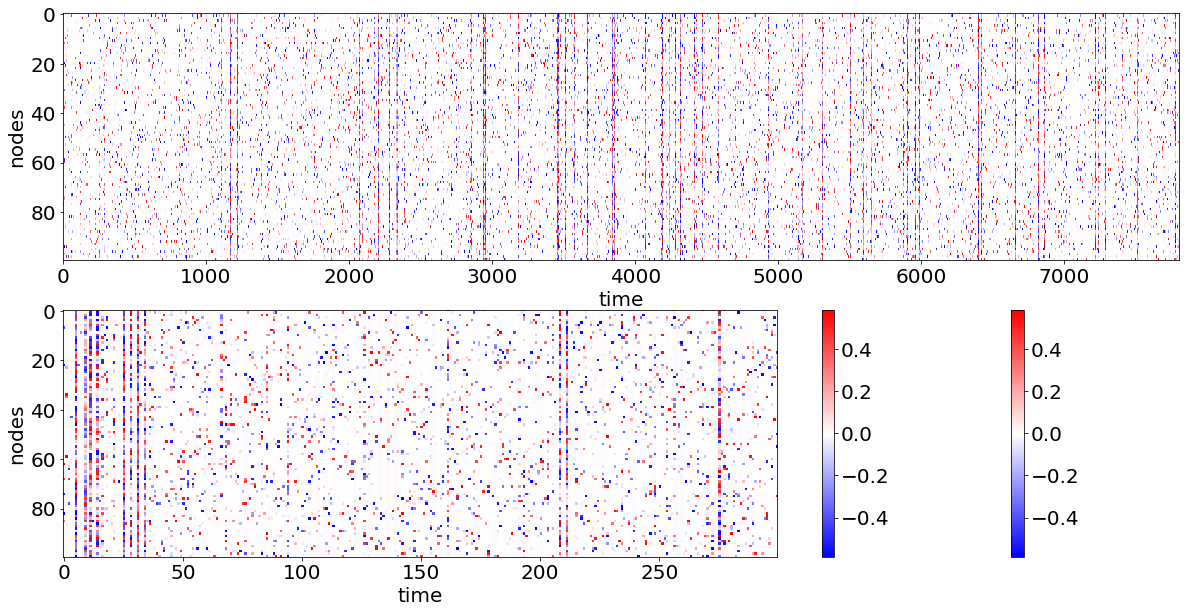

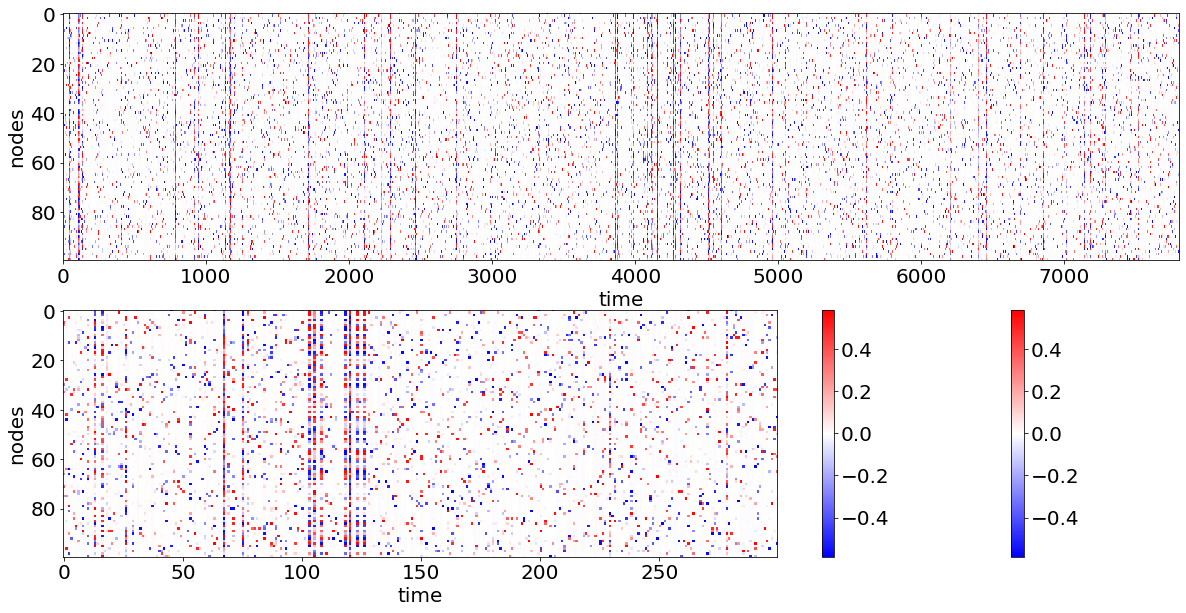

In [ ]:
import math
np.random.seed(1010)
dim_u_spon=0
dim_rv=100
dim_u=1
Time_leng=8000

input_scale=0.1
rho=60
density=1.0
a1=6.00
a2=6.01
b=10.0

def sync_func1(x):
  return np.tanh(a1*x)*np.exp(-b*x**2)

def sync_func2(x):
  return np.tanh(a2*x)*np.exp(-b*x**2)

u_ex=np.random.uniform(-1.0, 1.0, (Time_leng, dim_u))
rseed=1111
washout_len, states_series1=DESN_observer_1(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed, 
                                            activation_func=sync_func1, spon_eps=0.20, spon_r=4.0, plot=True, verbose=True)
rseed=1111
washout_len, states_series2=DESN_observer_2(u_ex, dim_u_spon, dim_rv, density, input_scale, rho, rseed, 
                                            activation_func=sync_func1, spon_eps=0.20, spon_r=4.0, plot=True, verbose=True)


shape =  (7800, 100)
[0.03977467 0.02326893 0.10396089 ... 0.05464918 0.05574661 0.05316855]
[-1.40039346 -1.63322367 -0.98313    ... -1.26241634 -1.25378155
 -1.27434519]


'\nind_arr=[0,1,2]\ndim_plot=len(ind_arr)\nax1=fig.subplots(dim_plot,1)\n\ntime=np.arange(Time_leng-washout_len)\nfor i in ind_arr:\n  ax1[i].plot(time, diff_series[:,i])\n\n'

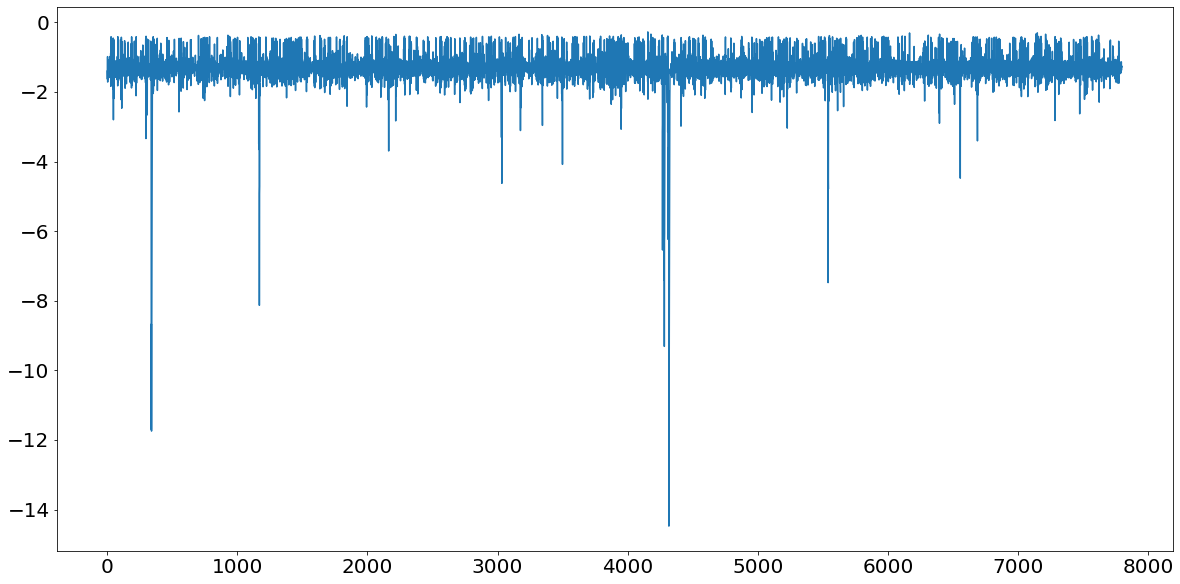

In [ ]:
print("shape = ",states_series1.shape)
diff_series = (np.sum(abs(states_series1-states_series2), axis=1)/dim_rv).reshape(-1) # sum direction
#np.logを使える
print(diff_series)
diff_series = np.log10(diff_series) # sum direction
print(diff_series)

plt.rcParams["figure.figsize"] = (20, 10) #(横, 縦)
plt.rcParams['font.size'] = 20
fig=plt.figure()

ax1=fig.subplots(1,1)

time=np.arange(Time_leng-washout_len)
plot_len=8000
ax1.plot(time[-plot_len:], diff_series[-plot_len:])

"""
ind_arr=[0,1,2]
dim_plot=len(ind_arr)
ax1=fig.subplots(dim_plot,1)

time=np.arange(Time_leng-washout_len)
for i in ind_arr:
  ax1[i].plot(time, diff_series[:,i])

"""